In [1]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import json
from huggingface_hub import hf_hub_download
import requests, zipfile, io
from datasets import load_dataset
from torch.utils.data import Dataset
import os
from PIL import Image
from torch.utils.data import DataLoader
import evaluate
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from transformers import (
    AutoImageProcessor,
    SegformerForSemanticSegmentation,
)
from torch.utils.tensorboard.writer import SummaryWriter

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
from tqdm import tqdm 

device = 'cuda'
model.to(device)
None

/home/void/test/venv/lib/python3.12/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [2]:
!ls ADEChallengeData2016/annotations

training  validation


In [3]:
# !cat ADEChallengeData2016/objectInfo150.txt

In [4]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        print(self.img_dir)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def get_name_file(self,idx):
        return os.path.join(self.img_dir, self.images[idx]),os.path.join(self.ann_dir, self.annotations[idx])

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [42]:
# segmentation_map = Image.open('ADEChallengeData2016/annotations/training/ADE_train_00000001.png')
# segmentation_map.size

(683, 512)

In [43]:
# Image.fromarray(np.array(segmentation_map)-1).size

(683, 512)

In [46]:
# np.unique(np.array(segmentation_map))

array([  0,   1,   4,   5,   6,  13,  18,  32,  33,  43,  44,  88,  97,
       105, 126, 139, 150], dtype=uint8)

In [45]:
# np.unique(np.array(segmentation_map)-1)

array([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104,
       125, 138, 149, 255], dtype=uint8)

In [35]:
# train_dataset.get_name_file(0)

('ADEChallengeData2016/images/training/ADE_train_00000001.jpg',
 'ADEChallengeData2016/annotations/training/ADE_train_00000001.png')

In [5]:
from transformers import SegformerImageProcessor

root_dir = 'ADEChallengeData2016'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

ADEChallengeData2016/images/training
ADEChallengeData2016/images/validation


In [6]:
# corrapted = []
# for i in tqdm(range(len(train_dataset))):
#     try:
#         train_dataset[i]
#     except:
#         corrapted.append(train_dataset.get_name_file(i))

In [7]:
# rm_rf_str = []
# for i in corrapted:
#     rm_rf_str.extend(i)
# rm_rf_str = ' '.join(rm_rf_str)
# rm_rf_str
                    

In [8]:
from torch.utils.data import DataLoader
batch_size=8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=14, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size,num_workers=14,)

In [9]:
# model.config.id2label

In [10]:
import os
import typing as tp
import torch

from copy import deepcopy
from torch import nn
from torch.nn import functional as F
# from tqdm.auto import tqdm



from torch import nn
from transformers.models.segformer.modeling_segformer import SegformerLayer

In [11]:
from typing import Dict

import torch
# from evaluate import load_metric
from torch import nn
import evaluate
from transformers import SegformerForSemanticSegmentation

def evaluate_model(model, valid_dataloader, id2label):
    metric = evaluate.load("mean_iou")
    predictions = []
    references = []

    with torch.no_grad():
        model.eval()
        for batch in valid_dataloader:
            pixel_values = batch["pixel_values"].cuda()
            labels = batch["labels"].cuda()
            logits = model(pixel_values=pixel_values, labels=labels)
            upsampled_logits = nn.functional.interpolate(
                logits.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )
            predicted = upsampled_logits.argmax(dim=1)
            predictions.append(predicted.detach().cpu().numpy())
            references.append(labels.detach().cpu().numpy())

        # note that the metric expects predictions + labels as numpy arrays

    metrics = metric._compute(
        predictions=predictions,
        references=references,
        num_labels=len(id2label),
        ignore_index=255,
        reduce_labels=False,  # we've already reduced the labels before)
    )

    print("Mean_iou:", metrics["mean_iou"])
    print("Mean accuracy:", metrics["mean_accuracy"])

    return metrics


In [12]:
m = evaluate_model(model, valid_dataloader, model.config.id2label)

Mean_iou: 0.36103305469415725
Mean accuracy: 0.4731817117838845


In [13]:
teacher_model = model

In [14]:
def create_small_network(model):
    future_list_names = {}

    for name, curr_module in model.named_modules():
        if isinstance(curr_module, nn.ModuleList):
            list_of_modules = [
                sub_module
                for sub_module in curr_module.children()
                if isinstance(sub_module, SegformerLayer)
            ]
            if len(list_of_modules) > 1:
                future_list_names[name] = nn.ModuleList([list_of_modules[-1]])

    setattr(model.segformer.encoder, 'block', nn.ModuleList(list(future_list_names.values())))

    return model

def n_params(model):
    return sum(p.numel() for p in model.parameters())

In [15]:
student_model = create_small_network(deepcopy(teacher_model))

In [16]:
n_params(teacher_model) / n_params(student_model)

1.6062923168193761

In [17]:
from dataclasses import dataclass

@dataclass
class TrainParams:
    n_epochs: int
    lr: float
    batch_size: int
    n_workers: int
    device: torch.device

    loss_weight: float
    last_layer_loss_weight: float
    intermediate_attn_layers_weights: tp.Tuple[float, float, float, float]
    intermediate_feat_layers_weights: tp.Tuple[float, float, float, float]



In [22]:
save_dir = 'distil'
tb_writer = SummaryWriter(save_dir)
def train(
    teacher_model,
    student_model,
    train_params: TrainParams,
    student_teacher_attention_mapping,
    tb_writer=tb_writer,
    save_dir='distil',
):
    metric = evaluate.load('mean_iou')
    teacher_model.to(train_params.device)
    student_model.to(train_params.device)

    teacher_model.eval()

    optimizer = torch.optim.AdamW(student_model.parameters(), lr=train_params.lr)
    step = 0
    for epoch in range(train_params.n_epochs):
        pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for idx, batch in pbar:
            student_model.train()
            # get the inputs;
            pixel_values = batch['pixel_values'].to(train_params.device)
            labels = batch['labels'].to(train_params.device)

            optimizer.zero_grad()

            # forward + backward + optimize
            student_outputs = student_model(
                pixel_values=pixel_values, 
                labels=labels, 
                output_attentions=True,
                output_hidden_states=True,
            )
            loss, student_logits = student_outputs.loss, student_outputs.logits

            # Чего это мы no_grad() при тренировке поставили?!
            with torch.no_grad():
                teacher_output = teacher_model(
                    pixel_values=pixel_values, 
                    labels=labels, 
                    output_attentions=True,
                    output_hidden_states=True,
                )


            last_layer_loss = calc_last_layer_loss(
                student_logits,
                teacher_output.logits,
                train_params.last_layer_loss_weight,
            )

            student_attentions, teacher_attentions = student_outputs.attentions, teacher_output.attentions
            student_hidden_states, teacher_hidden_states = student_outputs.hidden_states, teacher_output.hidden_states

            intermediate_layer_att_loss = calc_intermediate_layers_attn_loss(
                student_attentions,
                teacher_attentions,
                train_params.intermediate_attn_layers_weights,
                student_teacher_attention_mapping,
            )
            
            intermediate_layer_feat_loss = calc_intermediate_layers_feat_loss(
                student_hidden_states,
                teacher_hidden_states,
                train_params.intermediate_feat_layers_weights,
            )

            total_loss = loss* train_params.loss_weight + last_layer_loss
            if intermediate_layer_att_loss is not None:
                total_loss += intermediate_layer_att_loss
            
            if intermediate_layer_feat_loss is not None:
                total_loss += intermediate_layer_feat_loss

            step += 1

            total_loss.backward()
            optimizer.step()
            pbar.set_description(f'total loss: {total_loss.item():.3f}')

            for loss_value, loss_name in (
                (loss, 'loss'),
                (total_loss, 'total_loss'),
                (last_layer_loss, 'last_layer_loss'),
                (intermediate_layer_att_loss, 'intermediate_layer_att_loss'),
                (intermediate_layer_feat_loss, 'intermediate_layer_feat_loss'),
            ):
                if loss_value is None: # для выключенной дистилляции атеншенов
                    continue
                tb_writer.add_scalar(
                    tag=loss_name,
                    scalar_value=loss_value.item(),
                    global_step=step,
                )

        torch.save(
            {
                'model': student_model,
                'state_dict': student_model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
            },
            f'{save_dir}/ckpt_{epoch}.pth',
        )

        eval_metrics = evaluate_model(student_model, valid_dataloader, student_model.config.id2label)

        for metric_key, metric_value in eval_metrics.items():
            if not isinstance(metric_value, float):
                continue
            tb_writer.add_scalar(
                tag=f'eval_{metric_key}',
                scalar_value=metric_value,
                global_step=epoch,
            )


In [73]:
mse_loss = nn.MSELoss()
kl_loss = nn.KLDivLoss()

def calc_last_layer_loss(student_logits, teacher_logits, weight):
    return mse_loss(student_logits, teacher_logits) * weight
    



In [24]:
student_teacher_attention_mapping = {0: 1, 1: 3, 2: 5, 3: 7}

In [25]:
def calc_intermediate_layers_loss(student_attentions, teacher_attentions, weights, student_teacher_attention_mapping):
    intermediate_kl_loss = 0
    for i, (stud_attn_idx, teach_attn_idx) in enumerate(student_teacher_attention_mapping.items()):
        intermediate_kl_loss += weights[i] * kl_loss(
            input=torch.log(student_attentions[stud_attn_idx]),
            target=teacher_attentions[teach_attn_idx],
        )
    return intermediate_kl_loss

In [26]:
def calc_intermediate_layers_feat_loss(student_feats, teacher_feats, weights):
    intermediate_mse_loss = 0.
    for i in range(len(student_feats)):
        intermediate_mse_loss += weights[i] * mse_loss(
            input=student_feats[i],
            target=teacher_feats[i],
        )
    return intermediate_mse_loss

In [27]:
train_params = TrainParams(
    n_epochs=3,
    lr=6e-5,
    batch_size=8,
    n_workers=8,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    loss_weight=1,
    last_layer_loss_weight=0.,
    intermediate_attn_layers_weights=(0.5, 0.5, 0.5, 0.5),
    intermediate_feat_layers_weights=(0.5, 0.5, 0.5, 0.5),
)

In [28]:
train(
    teacher_model=teacher_model,
    student_model=deepcopy(student_model),
    train_params=train_params,
    student_teacher_attention_mapping=student_teacher_attention_mapping,
    tb_writer=tb_writer,
    save_dir=save_dir,
)


otal loss: 2.771: 100%|█████████████████████████████████████████████████████████████████████████████████| 2526/2526 [09:55<00:00,  4.24it/s]

Mean_iou: 0.3225399390426699
Mean accuracy: 0.4294977320749136



otal loss: 2.963: 100%|█████████████████████████████████████████████████████████████████████████████████| 2526/2526 [09:54<00:00,  4.25it/s]

Mean_iou: 0.33518421276488785
Mean accuracy: 0.4314515815548881



otal loss: 2.896: 100%|█████████████████████████████████████████████████████████████████████████████████| 2526/2526 [09:55<00:00,  4.24it/s]

Mean_iou: 0.33927428285885625
Mean accuracy: 0.43623544028562903


In [47]:
# model.config.id2label

In [48]:
# !cat ADEChallengeData2016/objectInfo150.txt

In [33]:
# import numpy as np 
# np.unique(train_dataset[0]['labels'].numpy())

array([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104,
       125, 138, 149, 255])

In [49]:
# train_dataset.get_name_file(0)

In [50]:
!ls distil

ckpt_0.pth
ckpt_1.pth
ckpt_2.pth
events.out.tfevents.1734576225.archlinux.8485.0
events.out.tfevents.1734576943.archlinux.10931.0
events.out.tfevents.1734577628.archlinux.12550.0
events.out.tfevents.1734578383.archlinux.14706.0


In [85]:
distilled_model = torch.load('distil/ckpt_2.pth')["model"]
teacher_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
teacher_model.to(device)
None

/tmp/ipykernel_14706/2204379903.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distilled_model = torch.load('distil/ckpt_2.pth')["model"]


In [52]:
evaluate_model(distilled_model, valid_dataloader, distilled_model.config.id2label)
None

Mean_iou: 0.33627428285885625
Mean accuracy: 0.43623544028562903


In [53]:
evaluate_model(teacher_model, valid_dataloader, teacher_model.config.id2label)
None

Mean_iou: 0.36103305469415725
Mean accuracy: 0.4731817117838845


In [86]:
import torch_pruning as tp
input_example = torch.rand(1,3,512,512, device="cuda")
ops, params = tp.utils.count_ops_and_params(teacher_model, input_example)
print(f"Baseline model complexity: {ops/1e6} MMAC, {params/1e6} M params")

Baseline model complexity: 7384.410112 MMAC, 3.752694 M params


In [87]:
ops, params = tp.utils.count_ops_and_params(distilled_model, input_example)
print(f"Distilled model complexity: {ops/1e6} MMAC, {params/1e6} M params")

Distilled model complexity: 6465.00096 MMAC, 2.336246 M params


In [88]:
import gc
model = None
torch.cuda.empty_cache()

In [89]:
import torch_pruning as tp
taylor_criteria = tp.importance.GroupTaylorImportance()
input_example = torch.rand(1,3,512,512, device="cuda")
ignored_layers = []
for name, module in distilled_model.named_modules():
    if name == "decode_head.classifier":
        ignored_layers.append(module)

pruner = tp.pruner.MetaPruner(
        distilled_model,
        example_inputs=input_example,
        importance=taylor_criteria,
        pruning_ratio=0.75,
        global_pruning=False,
        ignored_layers=ignored_layers,
    )

In [90]:
distilled_model.train()
for idx, batch in enumerate(tqdm(train_dataloader)):
    # get the inputs;
    pixel_values = batch["pixel_values"].to("cuda")
    labels = batch["labels"].to("cuda")

    # forward + backward + optimize
    outputs = distilled_model(pixel_values=pixel_values, labels=labels)
    loss, logits = outputs.loss, outputs.logits

    loss.backward()


00%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2526/2526 [06:00<00:00,  7.01it/s]

In [91]:
for i, g in enumerate(pruner.step(interactive=True)):
    g.prune()

In [92]:
from transformers.models.segformer.modeling_segformer import SegformerLayer, SegformerEfficientSelfAttention

for module in distilled_model.modules():
    if isinstance(module, SegformerEfficientSelfAttention):
        module.attention_head_size = module.attention_head_size // 4
        module.all_head_size = module.all_head_size // 4

In [93]:
ops, params = tp.utils.count_ops_and_params(distilled_model, input_example)
print(f"Distilled model complexity (After taylor pruning): {ops/1e6} MMAC, {params/1e6} M params")

Distilled model complexity (After taylor pruning): 550.512 MMAC, 0.160238 M params


In [94]:
save_dir = 'prune'
tb_writer = SummaryWriter(save_dir)

In [95]:
import typing
@dataclass
class TrainParams:
    n_epochs: int
    lr: float
    batch_size: int
    n_workers: int
    device: torch.device

    temperature: float
    loss_weight: float
    last_layer_loss_weight: float
    intermediate_layers_weights: typing.Tuple[float, float, float, float]
train_params = TrainParams(
    n_epochs=10,
    lr=1e-4,
    batch_size=16,
    n_workers=8,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    temperature=10,
    loss_weight=0.5,
    last_layer_loss_weight=0.5,
    intermediate_layers_weights=(0.5, 0.5, 0.5, 0.5),
)

In [96]:

def calc_last_layer_loss(student_logits, teacher_logits, temperature, weight):
    return kl_loss(
        input=F.log_softmax(student_logits / temperature, dim=-1),
        target=F.softmax(teacher_logits / temperature, dim=-1),
    ) * temperature ** 2
    return loss

def calc_intermediate_layers_loss(student_attentions, teacher_attentions, weights, student_teacher_attention_mapping):
    intermediate_kl_loss = 0
    for i, (stud_attn_idx, teach_attn_idx) in enumerate(student_teacher_attention_mapping.items()):
        intermediate_kl_loss += weights[i] * kl_loss(
            input=torch.log(student_attentions[stud_attn_idx]),
            target=teacher_attentions[teach_attn_idx],
        )
    return intermediate_kl_loss

def train(
    teacher_model,
    student_model,
    train_params: TrainParams,
    student_teacher_attention_mapping,
    tb_writer,
    save_dir,
):
    metric = evaluate.load('mean_iou')
    teacher_model.to(train_params.device)
    student_model.to(train_params.device)

    teacher_model.eval()

 

    optimizer = torch.optim.AdamW(student_model.parameters(), lr=train_params.lr)
    step = 0
    for epoch in range(train_params.n_epochs):
        pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for idx, batch in pbar:
            student_model.train()
            pixel_values = batch['pixel_values'].to(train_params.device)
            labels = batch['labels'].to(train_params.device)

            optimizer.zero_grad()

            student_outputs = student_model(pixel_values=pixel_values, labels=labels, output_attentions=True)
            loss, student_logits = student_outputs.loss, student_outputs.logits

            with torch.no_grad():
                teacher_output = teacher_model(pixel_values=pixel_values, labels=labels, output_attentions=True)


            last_layer_loss = calc_last_layer_loss(
                student_logits,
                teacher_output.logits,
                train_params.temperature,
                train_params.last_layer_loss_weight,
            )

            student_attentions, teacher_attentions = student_outputs.attentions, teacher_output.attentions

            intermediate_layer_loss = calc_intermediate_layers_loss(
                student_attentions,
                teacher_attentions,
                train_params.intermediate_layers_weights,
                student_teacher_attention_mapping,
            )

            total_loss = loss * train_params.loss_weight + last_layer_loss
            if intermediate_layer_loss is not None:
                total_loss += intermediate_layer_loss

            step += 1

            total_loss.backward()
            optimizer.step()
            pbar.set_description(f'total loss: {total_loss.item():.3f}')

            for loss_value, loss_name in (
                (loss, 'loss'),
                (total_loss, 'total_loss'),
                (last_layer_loss, 'last_layer_loss'),
                (intermediate_layer_loss, 'intermediate_loss'),

            ):
                if loss_value is None: 
                    continue
                tb_writer.add_scalar(
                    tag='loss_name',
                    scalar_value=loss_value.item(),
                    global_step=step,
                )

        torch.save(
            {
                'model': student_model,
                'state_dict': student_model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
            },
            f'{save_dir}/ckpt_{epoch}.pth',
        )

        eval_metrics = evaluate_model(student_model, valid_dataloader, student_model.config.id2label)

        for metric_key, metric_value in eval_metrics.items():
            if not isinstance(metric_value, float):
                continue
            tb_writer.add_scalar(
                tag=f'eval_{metric_key}',
                scalar_value=metric_value,
                global_step=epoch,
            )



In [97]:
train(
    teacher_model=teacher_model,
    student_model=deepcopy(distilled_model),
    train_params=train_params,
    student_teacher_attention_mapping=student_teacher_attention_mapping,
    tb_writer=tb_writer,
    save_dir=save_dir,
)


otal loss: 1.158: 100%|█████████████████████████████████████████████████████████████████████████████████| 2526/2526 [08:40<00:00,  4.85it/s]

Mean_iou: 0.203162984490462
Mean accuracy: 0.27617739104473876



otal loss: 0.905: 100%|█████████████████████████████████████████████████████████████████████████████████| 2526/2526 [08:41<00:00,  4.84it/s]

Mean_iou: 0.2359690789724595
Mean accuracy: 0.30320209761347188



otal loss: 0.951: 100%|█████████████████████████████████████████████████████████████████████████████████| 2526/2526 [08:41<00:00,  4.84it/s]

Mean_iou: 0.254198045234024574
Mean accuracy: 0.32577089057276448



otal loss: 1.120: 100%|█████████████████████████████████████████████████████████████████████████████████| 2526/2526 [08:40<00:00,  4.85it/s]

Mean_iou: 0.27636647347537965
Mean accuracy: 0.357638286365548505



otal loss: 1.054: 100%|█████████████████████████████████████████████████████████████████████████████████| 2526/2526 [08:40<00:00,  4.85it/s]

Mean_iou: 0.29115568926948165
Mean accuracy: 0.3725840250266807



otal loss: 0.841:   0%|▏                                                                                   | 4/2526 [00:01<15:26,  2.72it/s]

KeyboardInterrupt: 

In [99]:
!ls prune

ckpt_0.pth  ckpt_4.pth
ckpt_1.pth  events.out.tfevents.1734581428.archlinux.14706.1
ckpt_2.pth  events.out.tfevents.1734583012.archlinux.14706.2
ckpt_3.pth


In [102]:
prune_distilled_model = torch.load('prune/ckpt_4.pth')["model"]
teacher_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
teacher_model.to(device)
model = None
distilled_model =None
torch.cuda.empty_cache()

/tmp/ipykernel_14706/3290740123.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prune_distilled_model = torch.load('prune/ckpt_4.pth')["model"]


In [104]:
evaluate_model(prune_distilled_model, valid_dataloader, prune_distilled_model.config.id2label)
None

Mean_iou: 0.29115568926948165
Mean accuracy: 0.3725840250266807


In [105]:
import gc
model = None
torch.cuda.empty_cache()

In [106]:
from copy import deepcopy
from itertools import islice

import torch
from torch import nn
from torch.ao.quantization import get_default_qconfig_mapping
from torch.quantization.quantize_fx import convert_fx
from torch.quantization.quantize_fx import prepare_fx
from torch.utils.data import DataLoader
QCONFIG_MAPPING = get_default_qconfig_mapping("x86")

def quantize_static(
        model: nn.Module,
        data_loader: DataLoader,
        num_batches: int = 8,
        device: str = 'cuda'
) -> nn.Module:
  
    prepared_model = deepcopy(model)
    prepared_model.eval()
    example_input = next(iter(data_loader))
    prepared_model = prepare_fx(
        model=prepared_model,
        qconfig_mapping=QCONFIG_MAPPING,
        example_inputs=(example_input, ),
    )
   
    device = torch.device(device)

    prepared_model.eval()
    prepared_model.to(device)

    with torch.no_grad():
        for image, _ in islice(data_loader, num_batches):
            prepared_model(image.to(device))

 
    prepared_model.cpu()
    quantized_model = convert_fx(prepared_model)
    return quantized_model

In [107]:
calibrate_ds = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)
calibrate_dataloader = DataLoader(calibrate_ds, batch_size=batch_size,num_workers=14,)

ADEChallengeData2016/images/validation


In [109]:
# qaunt_prune_distilled_model =quantize_static(deepcopy(prune_distilled_model), calibrate_dataloader, num_batches=1)

In [115]:
# qaunt_prune_distilled_model = torch.quantization.quantize_dynamic(
#     deepcopy(prune_distilled_model), dtype=torch.qint8
# )


In [114]:
# evaluate_model(qaunt_prune_distilled_model, valid_dataloader, qaunt_prune_distilled_model.config.id2label)
# None

In [124]:
from datetime import timedelta
import time
from PIL import Image
import torch
import numpy as np  

def test_pt(model_test ,batch=1,it=30):
    with torch.inference_mode():
        torch.cuda.synchronize()
        #warm up 
        input_example = torch.rand(batch,3,512,512, device="cuda")
    
        for _ in range(10):
            model_test(input_example)
            torch.cuda.synchronize()
    
            
        starttime = time.perf_counter()
        for _ in range(it):
            model_test(input_example)
            torch.cuda.synchronize()
    
        return timedelta(seconds=time.perf_counter()-starttime)/it


In [140]:
b_o_1 = test_pt(prune_distilled_model).microseconds

In [133]:
m_o = evaluate_model(prune_distilled_model, valid_dataloader, prune_distilled_model.config.id2label)
None

Mean_iou: 0.29115568926948165
Mean accuracy: 0.3725840250266807


In [134]:
b_t_1 = test_pt(teacher_model).microseconds

In [135]:
m_t = evaluate_model(teacher_model, valid_dataloader, prune_distilled_model.config.id2label)
None

Mean_iou: 0.36103305469415725
Mean accuracy: 0.4731817117838845


In [136]:
b_o_10 = test_pt(prune_distilled_model,10).microseconds

In [137]:
b_t_10=test_pt(teacher_model,10).microseconds

In [138]:
b_o_20 = test_pt(prune_distilled_model,20).microseconds

In [139]:
b_t_20 = test_pt(teacher_model,20).microseconds

In [141]:
b_t_20/b_o_20

3.6833816244508832

In [143]:
b_t_10/b_o_10

3.5491360212671688

In [142]:
b_t_1/b_o_1

2.1645207439198857

In [149]:
test_opt =[]
test_base = []
for i in range(1,20,3):
    test_opt.append(test_pt(prune_distilled_model,i).microseconds)
    test_base.append(test_pt(teacher_model,i).microseconds)
    

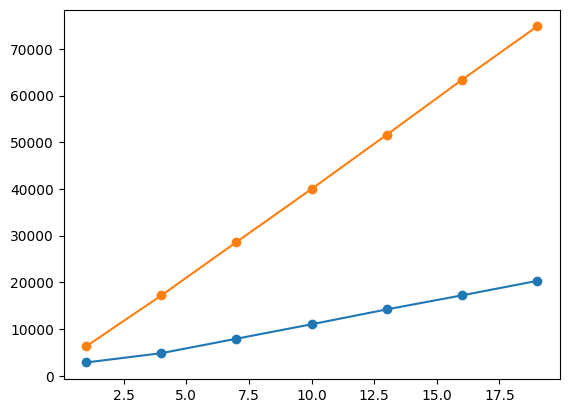

In [185]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,20,3)),test_opt , list(range(1,20,3)),test_base ,marker = 'o')
plt.show()

In [186]:
test_base[-1]/test_opt[-1]

3.682554532473288

In [182]:
m_o['mean_iou'],m_t['mean_iou'],m_o['mean_accuracy'],m_t['mean_accuracy']

(np.float64(0.29115568926948165),
 np.float64(0.36103305469415725),
 np.float64(0.3725840250266807),
 np.float64(0.4731817117838845))

In [183]:
float(m_o['mean_iou']/m_t['mean_iou']),float(m_o['mean_accuracy']/m_t['mean_accuracy'])

(0.8064516129032258, 0.7874015748031495)

<BarContainer object of 4 artists>

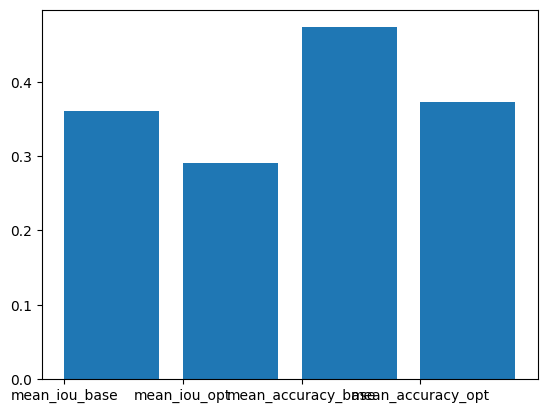

In [184]:
plt.bar(
    ['mean_iou_base','mean_iou_opt','mean_accuracy_base','mean_accuracy_opt'],
    [m_t['mean_iou'],m_o['mean_iou'],m_t['mean_accuracy'],m_o['mean_accuracy']]  ,align='edge'
)